#***Backend of the Code***

In [ ]:
# Install required packages
!pip install kagglehub tensorflow transformers

import kagglehub
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import matplotlib.pyplot as plt

# Download Dataset from Kaggle
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print("Path to dataset files:", path)

# Limit to first 1K images
import shutil
import glob

images_dir = os.path.join(path, "images")
limited_images_dir = "/content/fashion_images_limited"
os.makedirs(limited_images_dir, exist_ok=True)

image_files = sorted(glob.glob(f"{images_dir}/*.jpg"))[:1000]
for file in image_files:
    shutil.copy(file, limited_images_dir)

print(f"Dataset prepared with {len(image_files)} images.")

# Load and preprocess data
train_ds = tf.keras.utils.image_dataset_from_directory(
    limited_images_dir,
    labels='inferred',
    label_mode=None,  # No labels needed for feature extraction
    image_size=(224, 224),
    batch_size=32
).map(lambda x: (x / 255.0))  # Normalize pixel values




Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-small/versions/1
Dataset prepared with 1000 images.
Found 1000 files.


In [ ]:
!pip install torch torchvision transformers
!pip install albumentations


In [ ]:
import os
import random
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import random_split
from PIL import Image
import numpy as np
import torch.optim as optim


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the images from the folder
class FashionDataset(Dataset):
    def __init__(self, img_folder, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.image_paths = [os.path.join(img_folder, f) for f in os.listdir(img_folder)]
        random.shuffle(self.image_paths)
        self.image_paths = self.image_paths[:1000]  # Limit to 1000 images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path

# Initialize the dataset
dataset = FashionDataset("/content/fashion_images_limited", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Define the model architecture
class FashionModel(nn.Module):
    def __init__(self, cnn_backbone, transformer_dim=256, num_classes=2):
        super(FashionModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.avgpool = cnn_backbone.avgpool  # Extract avgpool layer before fully connected layer
        self.flatten = nn.Flatten()  # Flatten the pooled features
        self.fc = nn.Linear(2048, transformer_dim)  # Updated with hardcoded in_features value
        self.transformer = nn.Transformer(d_model=transformer_dim, nhead=4, num_encoder_layers=4)
        self.fc_out = nn.Linear(transformer_dim, num_classes)  # Final output layer

    def forward(self, x):
        x = self.cnn_backbone.conv1(x)
        x = self.cnn_backbone.bn1(x)
        x = self.cnn_backbone.relu(x)
        x = self.cnn_backbone.maxpool(x)

        # Pass through the remaining layers before the fully connected layer
        x = self.cnn_backbone.layer1(x)
        x = self.cnn_backbone.layer2(x)
        x = self.cnn_backbone.layer3(x)
        x = self.cnn_backbone.layer4(x)

        # Apply average pooling and flatten the features
        x = self.avgpool(x)
        x = self.flatten(x)

        # Pass through custom fully connected layer
        x = self.fc(x)
        x = x.unsqueeze(1)  # Add sequence dimension for Transformer
        x = self.transformer(x, x)  # Apply transformer
        x = x.mean(dim=1)  # Global average pooling across sequence
        x = self.fc_out(x)  # Final classification layer
        return x

# Load pre-trained ResNet50 model with updated weights argument
cnn_backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove the final classification layer
cnn_backbone.fc = nn.Identity()

# Create the FashionModel
model = FashionModel(cnn_backbone)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)  # Ensure the model is on the correct device

# Contrastive loss function
def contrastive_loss(x1, x2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(x1, x2, 2)
    loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                      (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train the model (example with 1 epoch)
model.train()
for epoch in range(1):  # Example for 1 epoch
    running_loss = 0.0
    for i, (inputs, _) in enumerate(dataloader):
        # Simulate label pairs for contrastive loss (positive and negative pairs)
        labels = torch.randint(0, 2, (inputs.size(0) // 2,)).float().to(device)  # Random binary labels for now

        inputs = inputs.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Create some synthetic positive and negative pairs
        x1, x2 = outputs[::2], outputs[1::2]  # Pair outputs
        loss = contrastive_loss(x1, x2, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")


#**Compute the similarity of the Given Input**

In [ ]:
# input i the code it self
def get_image_features(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.cnn_backbone(image)
    return features.squeeze().cpu().numpy()

def get_similar_images(query_image_path, dataset, model, top_k=5):
    query_features = get_image_features(model, query_image_path)

    # Compute the similarity (cosine similarity)
    similarities = []
    for img_path in dataset.image_paths:
        img_features = get_image_features(model, img_path)
        sim = np.dot(query_features, img_features) / (np.linalg.norm(query_features) * np.linalg.norm(img_features))
        similarities.append((img_path, sim))

    # Sort by similarity and get top-k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Test retrieval
query_image_path = "/content/fashion_images_limited/21526.jpg"
top_k_images = get_similar_images(query_image_path, dataset, model, top_k=10)
print("Top 10 similar images:")
for img_path, sim in top_k_images:
    print(f"{img_path}: Similarity: {sim}")


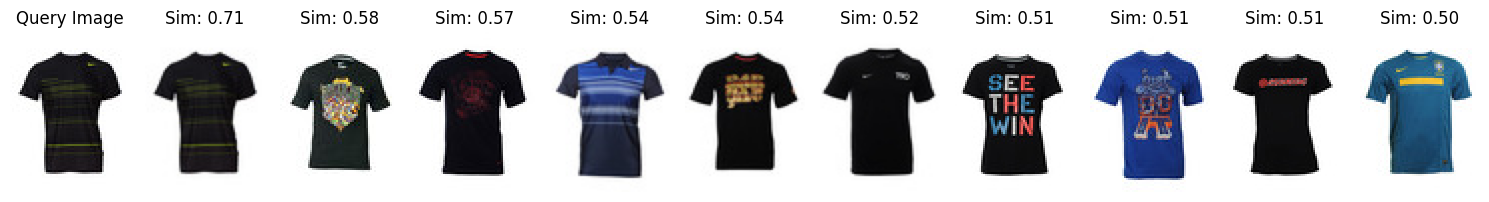

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def display_similar_images(query_image_path, similar_images):
    """
    Display the query image and its top similar images in a grid.

    Args:
        query_image_path (str): Path to the query image.
        similar_images (list of tuples): List of (image_path, similarity_score) for similar images.
    """
    num_images = len(similar_images) + 1  # Include the query image
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    # Display the query image
    query_image = Image.open(query_image_path).convert("RGB")
    axes[0].imshow(query_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Display the similar images
    for i, (img_path, sim_score) in enumerate(similar_images):
        similar_image = Image.open(img_path).convert("RGB")
        axes[i + 1].imshow(similar_image)
        axes[i + 1].set_title(f"Sim: {sim_score:.2f}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
display_similar_images(query_image_path, top_k_images)


#**Evaluation**

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import time

def evaluate_retrieval(query_image_path, dataset, model, top_k=10, ground_truth_paths=None):
    """
    Evaluate the retrieval system with various metrics.

    Args:
        query_image_path (str): Path to the query image.
        dataset (FashionDataset): Dataset for comparison.
        model (FashionModel): Trained model for feature extraction.
        top_k (int): Number of top similar images to consider.
        ground_truth_paths (list of str): List of ground truth image paths for the query.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    start_time = time.time()

    # Get top-k similar images
    retrieved_images = get_similar_images(query_image_path, dataset, model, top_k=top_k)

    inference_time = (time.time() - start_time) * 1000  # Convert to milliseconds

    # Extract paths and similarities
    retrieved_paths = [img_path for img_path, _ in retrieved_images]

    # If ground truth is not provided, simulate it (e.g., images in the same category as query)
    if ground_truth_paths is None:
        ground_truth_paths = [query_image_path]

    # Generate binary relevance labels for evaluation
    y_true = [1 if path in ground_truth_paths else 0 for path in retrieved_paths]
    y_pred = [1] * len(retrieved_paths)  # All retrieved images are considered relevant

    # Precision, Recall, F1-Score
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Cosine Similarity (Average similarity score of top-k retrieved images)
    cosine_similarity_scores = [sim for _, sim in retrieved_images]
    average_cosine_similarity = sum(cosine_similarity_scores) / len(cosine_similarity_scores)

    # Diversity (Average pairwise cosine distance among retrieved images)
    features = [get_image_features(model, path) for path in retrieved_paths]
    diversity_scores = [
        1 - np.dot(features[i], features[j]) / (np.linalg.norm(features[i]) * np.linalg.norm(features[j]))
        for i in range(len(features)) for j in range(i + 1, len(features))
    ]
    diversity = sum(diversity_scores) / len(diversity_scores) if diversity_scores else 0

    # Results
    metrics = {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Cosine Similarity": average_cosine_similarity,
        "Diversity": diversity,
        "Inference Time (ms)": inference_time,
    }

    return metrics


# Example usage
query_image_path = input("Enter the path to the query image: ")
ground_truth_paths = ["/content/fashion_images_limited/10010.jpg", "/content/fashion_images_limited/10020.jpg"]  # Replace with actual ground truth paths

metrics = evaluate_retrieval(query_image_path, dataset, model, top_k=10, ground_truth_paths=ground_truth_paths)

# Display results
print("\nEvaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")


#**Table representation of output images and its Description**

In [ ]:
# Load the CSV file instead of an Excel file
# Load the CSV file with error handling
import pandas as pd
excel_file_path = "/content/styles.csv"  # Replace with your file path
metadata_df = pd.read_csv(excel_file_path, on_bad_lines='skip')  # Skip problematic rows
from csv import QUOTE_NONE

metadata_df = pd.read_csv(excel_file_path, on_bad_lines='skip', quoting=QUOTE_NONE)
with open(excel_file_path, 'r') as file:
    for i, line in enumerate(file):
        if i == 6044:  # Check the problematic line number
            print(line)


# Display the first few rows to verify
print(metadata_df.head())


def get_metadata(image_path, metadata_df):
    """
    Retrieve metadata for a given image path based on its ID.

    Args:
        image_path (str): Path to the image file.
        metadata_df (DataFrame): Pandas DataFrame containing metadata.

    Returns:
        dict: A dictionary containing the metadata for the given image.
    """
    image_id = int(image_path.split('/')[-1].split('.')[0])  # Extract ID from image name
    metadata = metadata_df[metadata_df['id'] == image_id]
    if not metadata.empty:
        return metadata.iloc[0].to_dict()  # Convert the first matching row to a dictionary
    return None

def create_similar_images_table(query_image_path, similar_images, metadata_df):
    """
    Create a table with similar images and their metadata.

    Args:
        query_image_path (str): Path to the query image.
        similar_images (list of tuples): List of (image_path, similarity_score).
        metadata_df (DataFrame): Pandas DataFrame containing metadata.

    Returns:
        DataFrame: A pandas DataFrame with similar images and their metadata.
    """
    data = []
    for img_path, sim_score in similar_images:
        metadata = get_metadata(img_path, metadata_df)
        if metadata:
            data.append({
                "Image Path": img_path,
                "Similarity Score": sim_score,
                "Gender": metadata['gender'],
                "Article Type": metadata['articleType'],
                "Base Colour": metadata['baseColour'],
                "Usage": metadata['usage'],
                "Product Display Name": metadata['productDisplayName']
            })

    # Convert to a DataFrame for better display
    similar_images_df = pd.DataFrame(data)
    return similar_images_df

# Example usage
#query_image_path = "/content/fashion_images_limited/11261.jpg"  # Replace with your query image path
#top_k_images = get_similar_images(query_image_path, dataset, model, top_k=5)

# Generate the table
similar_images_table = create_similar_images_table(query_image_path, top_k_images, metadata_df)

# Display the table
display(similar_images_table)


5342,Men,Footwear,Shoes,Casual Shoes,Green,Summer,2011,Casual,Fila Men's Fitness Hiker Olive Black Yellow Shoe

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


,Image Path,Similarity Score,Gender,Article Type,Base Colour,Usage,Product Display Name
0,/content/fashion_images_limited/10010.jpg,0.714773,Men,Tshirts,Black,Sports,Nike Men As Showdown F Black T-Shirts
1,/content/fashion_images_limited/10708.jpg,0.581324,Men,Tshirts,Black,Casual,Nike Men Logo T-shirt Black Tshirts
2,/content/fashion_images_limited/10031.jpg,0.574194,Men,Tshirts,Navy Blue,Sports,Nike Men As Arsenal Co Navy Blue T-Shirts
3,/content/fashion_images_limited/10022.jpg,0.544092,Men,Tshirts,Blue,Sports,Nike Men Blue Polo Tshirts
4,/content/fashion_images_limited/10032.jpg,0.536444,Men,Tshirts,Black,Sports,Nike Men AS FCB Core T Black T-shirts
5,/content/fashion_images_limited/10006.jpg,0.518657,Men,Tshirts,Black,Sports,Nike Men AS T90 Black Tshirts
6,/content/fashion_images_limited/10030.jpg,0.512973,Women,Tshirts,Black,Sports,Nike Women As See The Win Black T-Shirts
7,/content/fashion_images_limited/10750.jpg,0.511090,Men,Tshirts,Blue,Sports,Nike Men Remix Crew Blue Tshirts
8,/content/fashion_images_limited/10026.jpg,0.505099,Women,Tshirts,Black,Sports,Nike Women As Challenger Black T-Shirts
9,/content/fashion_images_limited/10601.jpg,0.498654,Men,Tshirts,Blue,Sports,Nike Men Football Soccer Blue Jerseys


Image,Similarity Score,Gender,Article Type,Base Colour,Usage,Product Display Name
,0.714773,Men,Tshirts,Black,Sports,Nike Men As Showdown F Black T-Shirts
,0.581324,Men,Tshirts,Black,Casual,Nike Men Logo T-shirt Black Tshirts
,0.574194,Men,Tshirts,Navy Blue,Sports,Nike Men As Arsenal Co Navy Blue T-Shirts
,0.544092,Men,Tshirts,Blue,Sports,Nike Men Blue Polo Tshirts
,0.536444,Men,Tshirts,Black,Sports,Nike Men AS FCB Core T Black T-shirts
,0.518657,Men,Tshirts,Black,Sports,Nike Men AS T90 Black Tshirts
,0.512973,Women,Tshirts,Black,Sports,Nike Women As See The Win Black T-Shirts
,0.511090,Men,Tshirts,Blue,Sports,Nike Men Remix Crew Blue Tshirts
,0.505099,Women,Tshirts,Black,Sports,Nike Women As Challenger Black T-Shirts
,0.498654,Men,Tshirts,Blue,Sports,Nike Men Football Soccer Blue Jerseys

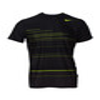
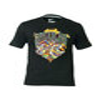
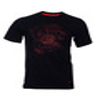
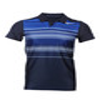
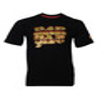
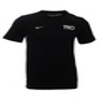
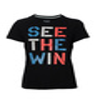
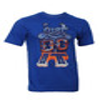
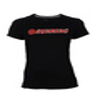
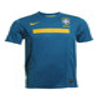

In [ ]:
from IPython.display import HTML, display
from PIL import Image
import base64
from io import BytesIO
import pandas as pd
def encode_image_to_html(image_path):
    """
    Convert an image to a base64-encoded HTML image tag for display in a Jupyter notebook.

    Args:
        image_path (str): Path to the image file.

    Returns:
        str: Base64-encoded HTML image tag.
    """
    try:
        image = Image.open(image_path).resize((100, 100))  # Resize for display
        buffer = BytesIO()
        image.save(buffer, format="PNG")
        buffer.seek(0)
        image_base64 = base64.b64encode(buffer.read()).decode("utf-8")
        return f'<img src="data:image/png;base64,{image_base64}" style="display:block;margin:auto"/>'
    except Exception as e:
        print(f"Error encoding image {image_path}: {e}")
        return "Image not available"

def create_similar_images_table_with_images(query_image_path, similar_images, metadata_df):
    """
    Create a table with similar images and their metadata, including thumbnails of the images.

    Args:
        query_image_path (str): Path to the query image.
        similar_images (list of tuples): List of (image_path, similarity_score).
        metadata_df (DataFrame): Pandas DataFrame containing metadata.

    Returns:
        DataFrame: A pandas DataFrame with similar images (thumbnails) and their metadata.
    """
    data = []
    for img_path, sim_score in similar_images:
        metadata = get_metadata(img_path, metadata_df)
        if metadata:
            data.append({
                "Image": encode_image_to_html(img_path),  # Add image thumbnail
                "Similarity Score": sim_score,
                "Gender": metadata['gender'],
                "Article Type": metadata['articleType'],
                "Base Colour": metadata['baseColour'],
                "Usage": metadata['usage'],
                "Product Display Name": metadata['productDisplayName']
            })

    # Convert to a DataFrame for better display
    similar_images_df = pd.DataFrame(data)
    return similar_images_df

# Generate the table with images
#query_image_path = "/content/fashion_images_limited/10650.jpg"  # Replace with your query image path
#top_k_images = get_similar_images(query_image_path, dataset, model, top_k=5)
similar_images_table = create_similar_images_table_with_images(query_image_path, top_k_images, metadata_df)

# Render the table with HTML
html_table = similar_images_table.to_html(escape=False, index=False)  # Disable escaping for HTML tags
display(HTML(html_table))


#***Table representation of the model architecture***

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torchvision import models
import pandas as pd

# Define the Model Architecture
class FashionModel(nn.Module):
    def __init__(self, cnn_backbone, transformer_dim=256, num_classes=2):
        super(FashionModel, self).__init__()
        self.cnn_backbone = cnn_backbone
        self.avgpool = cnn_backbone.avgpool  # Global average pooling from ResNet
        self.flatten = nn.Flatten()  # Flatten the pooled features
        self.fc = nn.Linear(2048, transformer_dim)  # Dimensionality reduction
        self.transformer = nn.Transformer(
            d_model=transformer_dim, nhead=4, num_encoder_layers=4, num_decoder_layers=4
        )  # Transformer encoder-decoder
        self.fc_out = nn.Linear(transformer_dim, num_classes)  # Final output layer

    def forward(self, x):
        x = self.cnn_backbone.conv1(x)
        x = self.cnn_backbone.bn1(x)
        x = self.cnn_backbone.relu(x)
        x = self.cnn_backbone.maxpool(x)
        x = self.cnn_backbone.layer1(x)
        x = self.cnn_backbone.layer2(x)
        x = self.cnn_backbone.layer3(x)
        x = self.cnn_backbone.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)

        x = self.fc(x)
        x = x.unsqueeze(1)  # Add sequence dimension for the Transformer
        x = self.transformer(x, x)
        x = x.mean(dim=1)  # Global average pooling across sequence
        x = self.fc_out(x)
        return x

# Load ResNet-50 Backbone
cnn_backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
cnn_backbone.fc = nn.Identity()  # Remove the final classification layer

# Initialize the Model
model = FashionModel(cnn_backbone)

# Function to extract and display model layers in a table
def get_model_architecture_table(model, input_size=(1, 3, 224, 224)):
    input_tensor = torch.randn(input_size)
    hooks = []
    layers_info = []

    # Hook to capture layer outputs
    def hook_fn(module, input, output):
        layers_info.append({
            "Layer Name": module.__class__.__name__,
            "Output Shape": list(output.shape)
        })

    # Register hooks on all layers
    for name, layer in model.named_modules():
        if len(list(layer.children())) == 0:  # Only leaf layers
            hooks.append(layer.register_forward_hook(hook_fn))

    # Run a forward pass to capture the outputs
    with torch.no_grad():
        _ = model(input_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return pd.DataFrame(layers_info)

# Get the model architecture table
architecture_table = get_model_architecture_table(model)
print(architecture_table)

# Display the table
from IPython.display import display
display(architecture_table)


      Layer Name       Output Shape
0         Conv2d  [1, 64, 112, 112]
1    BatchNorm2d  [1, 64, 112, 112]
2           ReLU  [1, 64, 112, 112]
3      MaxPool2d    [1, 64, 56, 56]
4         Conv2d    [1, 64, 56, 56]
..           ...                ...
221       Linear        [1, 1, 256]
222      Dropout        [1, 1, 256]
223    LayerNorm        [1, 1, 256]
224    LayerNorm        [1, 1, 256]
225       Linear             [1, 2]

[226 rows x 2 columns]


,Layer Name,Output Shape
0,Conv2d,"[1, 64, 112, 112]"
1,BatchNorm2d,"[1, 64, 112, 112]"
2,ReLU,"[1, 64, 112, 112]"
3,MaxPool2d,"[1, 64, 56, 56]"
4,Conv2d,"[1, 64, 56, 56]"
...,...,...
221,Linear,"[1, 1, 256]"
222,Dropout,"[1, 1, 256]"
223,LayerNorm,"[1, 1, 256]"
224,LayerNorm,"[1, 1, 256]"


In [ ]:
from PIL import Image
from torchvision import transforms

def preprocess_and_save_image(input_image_path, output_image_path, target_size=(224, 224)):
    """
    Preprocess an image by resizing it to the target dimensions and saving it with a new name.

    Args:
        input_image_path (str): Path to the original image.
        output_image_path (str): Path to save the preprocessed image.
        target_size (tuple): Target size for resizing (width, height).
    """
    # Load the image
    image = Image.open(input_image_path).convert("RGB")

    # Define the transformation
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
    ])

    # Apply the transformation
    transformed_image = transform(image)

    # Convert back to PIL format and save
    transformed_image_pil = transforms.ToPILImage()(transformed_image)
    transformed_image_pil.save(output_image_path)

# Example usage
input_image_path = "/content/my_derss.jpg"  # Replace with your image path
output_image_path = "/content/preprocessed_image.jpg"  # New name for the preprocessed image
preprocess_and_save_image(input_image_path, output_image_path, target_size=(224, 224))

print(f"Preprocessed image saved at: {output_image_path}")


Preprocessed image saved at: /content/preprocessed_image.jpg


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
from torchvision import models

# Define the Model Architecture
class FashionModel(nn.Module):
    def __init__(self, cnn_backbone, transformer_dim=256, num_classes=2):
        super(FashionModel, self).__init__()
        # ResNet-50 Backbone
        self.cnn_backbone = cnn_backbone
        self.avgpool = cnn_backbone.avgpool  # Global average pooling from ResNet
        self.flatten = nn.Flatten()  # Flatten the pooled features
        self.fc = nn.Linear(2048, transformer_dim)  # Dimensionality reduction
        self.transformer = nn.Transformer(
            d_model=transformer_dim, nhead=4, num_encoder_layers=4, num_decoder_layers=4
        )  # Transformer encoder-decoder
        self.fc_out = nn.Linear(transformer_dim, num_classes)  # Final output layer

    def forward(self, x):
        # Pass through ResNet backbone
        x = self.cnn_backbone.conv1(x)
        x = self.cnn_backbone.bn1(x)
        x = self.cnn_backbone.relu(x)
        x = self.cnn_backbone.maxpool(x)
        x = self.cnn_backbone.layer1(x)
        x = self.cnn_backbone.layer2(x)
        x = self.cnn_backbone.layer3(x)
        x = self.cnn_backbone.layer4(x)

        # Apply average pooling and flatten the features
        x = self.avgpool(x)
        x = self.flatten(x)

        # Dimensionality reduction for transformer input
        x = self.fc(x)
        x = x.unsqueeze(1)  # Add sequence dimension for the Transformer
        x = self.transformer(x, x)  # Pass through transformer
        x = x.mean(dim=1)  # Global average pooling across the sequence
        x = self.fc_out(x)  # Final classification layer
        return x

# Load ResNet-50 Backbone
cnn_backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Remove the final classification layer
cnn_backbone.fc = nn.Identity()

# Initialize the Model
model = FashionModel(cnn_backbone)
print(model)

# Example Input
example_input = torch.randn(1, 3, 224, 224)  # Batch size = 1, Channels = 3, Image Size = 224x224
output = model(example_input)

# Print Output Shape
print("Output Shape:", output.shape)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


FashionModel(
  (cnn_backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [ ]:
# give the input after running the code
def get_image_features(model, image_path):
    """
    Extract features from a single image using the CNN backbone of the model.

    Args:
        model (FashionModel): Trained model with CNN backbone.
        image_path (str): Path to the input image.

    Returns:
        numpy.ndarray: Extracted features as a 1D numpy array.
    """
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Preprocess the image and move to the device
    with torch.no_grad():
        features = model.cnn_backbone(image)  # Extract features using the CNN backbone
    return features.squeeze().cpu().numpy()


def get_similar_images(query_image_path, dataset, model, top_k=5):
    """
    Retrieve similar images from the dataset based on cosine similarity.

    Args:
        query_image_path (str): Path to the query image.
        dataset (FashionDataset): Dataset containing images for comparison.
        model (FashionModel): Trained model for feature extraction.
        top_k (int): Number of top similar images to retrieve.

    Returns:
        list of tuples: List of (image_path, similarity_score) for top-k similar images.
    """
    query_features = get_image_features(model, query_image_path)

    # Compute cosine similarity with all images in the dataset
    similarities = []
    for img_path in dataset.image_paths:
        img_features = get_image_features(model, img_path)
        sim = np.dot(query_features, img_features) / (
            np.linalg.norm(query_features) * np.linalg.norm(img_features)
        )
        similarities.append((img_path, sim))

    # Sort by similarity and get top-k results
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]


# User input for the query image path
query_image_path = input("Enter the path to the query image (e.g., /content/fashion_images_limited/10010.jpg): ")

# Retrieve top-k similar images
top_k_images = get_similar_images(query_image_path, dataset, model, top_k=10)

# Print the results
print("Top 10 similar images:")
for img_path, sim in top_k_images:
    print(f"{img_path}: Similarity: {sim}")


Enter the path to the query image (e.g., /content/fashion_images_limited/10010.jpg): /content/fashion_images_limited/21526.jpg


NameError: name 'dataset' is not defined